In [1]:
import soundfile # to read audio file
import numpy as np
import pandas as pd
import librosa # to extract speech features
import glob
import os
import pickle 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model, to_categorical

In [2]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if (len(X.shape) != 1):
            if (X.shape[1] == 2):
                X = X[:,0]
            else:
                return [None]
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [8]:
## codes in data
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# only files with these emotion labels are used
emotions_dict ={
    "angry": 0,
    "sad": 1,
    "neutral": 2,
    "happy": 3,
    "calm": 4
}

category_to_emotion = {}

for key in emotions_dict.keys():
    value = emotions_dict[key]
    category_to_emotion[value] = key

In [9]:
def load_data(test_size=0.2, max_amount=10000):
    i = 0
    X, y = [], []
    amount = 0
    for file in glob.glob("ravdess/Audio*/Actor_*/*.wav"):
        if (amount >= max_amount):
            break
        
        basename = os.path.basename(file)
        
        emotion = int2emotion[basename.split("-")[2]]
        allowed_emotions = emotions_dict.keys()
        
        if emotion not in allowed_emotions:
            continue
        emotion_category = emotions_dict[emotion]
        
        features = extract_feature(file, mfcc=True, mel=True)
        
        ## there seems to be some unusable data so lets get rid of those
        if (features[0] == None):
            continue
        
        
            
        X.append(features)
        y.append(emotion_category)
        amount = amount + 1
        
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [10]:
max_amount_of_data = 100000
X_train, X_test, y_train, y_test = load_data(test_size=0.25, max_amount=max_amount_of_data)

In [12]:

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


y_train = np.asarray(y_train)
y_train = y_train.astype(np.float32)
y_test = np.asarray(y_test)
y_test = y_test.astype(np.float32)

nb_classes = len(emotions_dict.keys())
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

In [13]:
print("[+] Number of training samples:", X_train.shape[0])
print("[+] Train shape", X_train.shape)
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])


[+] Number of training samples: 648
[+] Train shape (648, 168)
[+] Number of testing samples: 216
[+] Number of features: 168


In [24]:
print("[+] X_train first value's first 5 values", X_train[0][0:5])
print("[+] y_train first value", y_train[0])

[+] X_train first value's first 5 values [-624.8846      81.437775     6.1550703   10.636216     5.9423804]
[+] y_train first value [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


# Complicated model

In [11]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
x_traincnn.shape

(504, 168, 1)

In [12]:
inputs = keras.Input(shape=(x_traincnn.shape[1], x_traincnn.shape[2]))
x = layers.Conv1D(128, 5, activation="relu", padding="same")(inputs)

x = layers.Dropout(rate=0.1)(x)

x = layers.MaxPooling1D(pool_size=(8))(x)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)


output_units = len(emotions_dict.keys())
outputs = layers.Dense(units=output_units, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="mlp_model")
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
print(model.summary())

Model: "mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 168, 128)          768       
_________________________________________________________________
dropout (Dropout)            (None, 168, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 21, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 128)           82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2688)              0 

C:\Users\samul\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
epochs = 200

history = model.fit(x_traincnn, y_train, 
                    epochs=epochs, 
                    batch_size=32,
                    verbose=2)

Epoch 1/200
16/16 - 6s - loss: 4.4006 - accuracy: 0.2282
Epoch 2/200
16/16 - 0s - loss: 3.0028 - accuracy: 0.2937
Epoch 3/200
16/16 - 0s - loss: 3.0041 - accuracy: 0.2917
Epoch 4/200
16/16 - 0s - loss: 2.6912 - accuracy: 0.3075
Epoch 5/200
16/16 - 0s - loss: 2.7070 - accuracy: 0.3135
Epoch 6/200
16/16 - 0s - loss: 2.7177 - accuracy: 0.3016
Epoch 7/200
16/16 - 0s - loss: 2.6039 - accuracy: 0.3294
Epoch 8/200
16/16 - 0s - loss: 2.6529 - accuracy: 0.2877
Epoch 9/200
16/16 - 0s - loss: 2.5328 - accuracy: 0.3532
Epoch 10/200
16/16 - 0s - loss: 2.4098 - accuracy: 0.3433
Epoch 11/200
16/16 - 0s - loss: 2.1965 - accuracy: 0.3790
Epoch 12/200
16/16 - 0s - loss: 2.2357 - accuracy: 0.3730
Epoch 13/200
16/16 - 0s - loss: 2.2391 - accuracy: 0.3571
Epoch 14/200
16/16 - 0s - loss: 2.3159 - accuracy: 0.3234
Epoch 15/200
16/16 - 0s - loss: 1.9818 - accuracy: 0.4107
Epoch 16/200
16/16 - 0s - loss: 2.0762 - accuracy: 0.3810
Epoch 17/200
16/16 - 0s - loss: 2.1602 - accuracy: 0.3472
Epoch 18/200
16/16 - 0s

Epoch 142/200
16/16 - 0s - loss: 0.9124 - accuracy: 0.5952
Epoch 143/200
16/16 - 0s - loss: 0.9085 - accuracy: 0.5833
Epoch 144/200
16/16 - 0s - loss: 0.9342 - accuracy: 0.5794
Epoch 145/200
16/16 - 0s - loss: 0.8950 - accuracy: 0.5952
Epoch 146/200
16/16 - 0s - loss: 0.9019 - accuracy: 0.5754
Epoch 147/200
16/16 - 0s - loss: 0.8764 - accuracy: 0.6151
Epoch 148/200
16/16 - 0s - loss: 0.8981 - accuracy: 0.5992
Epoch 149/200
16/16 - 0s - loss: 0.8924 - accuracy: 0.5992
Epoch 150/200
16/16 - 0s - loss: 0.8999 - accuracy: 0.6071
Epoch 151/200
16/16 - 0s - loss: 0.9151 - accuracy: 0.5893
Epoch 152/200
16/16 - 0s - loss: 0.8843 - accuracy: 0.5952
Epoch 153/200
16/16 - 0s - loss: 0.9032 - accuracy: 0.5952
Epoch 154/200
16/16 - 0s - loss: 0.9059 - accuracy: 0.5794
Epoch 155/200
16/16 - 0s - loss: 0.8772 - accuracy: 0.6032
Epoch 156/200
16/16 - 0s - loss: 0.8864 - accuracy: 0.5992
Epoch 157/200
16/16 - 0s - loss: 0.8813 - accuracy: 0.6151
Epoch 158/200
16/16 - 0s - loss: 0.8671 - accuracy: 0.61

# Simple model

In [71]:
inputs = keras.Input(shape=(X_train.shape[1], ))
x = layers.Dense(28)(inputs)
x = layers.Dense(28)(x)

output_units = len(emotions_dict.keys())
outputs = layers.Dense(units=output_units, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="mlp_model")
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
print(model.summary())

Model: "mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 168)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 28)                4732      
_________________________________________________________________
dense_9 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 116       
Total params: 5,660
Trainable params: 5,660
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
epochs = 200

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=32,
                    verbose=2)

Epoch 1/200
31/31 - 2s - loss: 123.9894 - accuracy: 0.2806
Epoch 2/200
31/31 - 0s - loss: 102.3614 - accuracy: 0.2806
Epoch 3/200
31/31 - 0s - loss: 82.2412 - accuracy: 0.2806
Epoch 4/200
31/31 - 0s - loss: 62.2729 - accuracy: 0.2806
Epoch 5/200
31/31 - 0s - loss: 43.4414 - accuracy: 0.2806
Epoch 6/200
31/31 - 0s - loss: 27.6179 - accuracy: 0.3283
Epoch 7/200
31/31 - 0s - loss: 18.3080 - accuracy: 0.3394
Epoch 8/200
31/31 - 0s - loss: 11.8405 - accuracy: 0.3222
Epoch 9/200
31/31 - 0s - loss: 8.9512 - accuracy: 0.3100
Epoch 10/200
31/31 - 0s - loss: 6.2894 - accuracy: 0.3232
Epoch 11/200
31/31 - 0s - loss: 4.3413 - accuracy: 0.3202
Epoch 12/200
31/31 - 0s - loss: 4.0018 - accuracy: 0.3121
Epoch 13/200
31/31 - 0s - loss: 3.7491 - accuracy: 0.3394
Epoch 14/200
31/31 - 0s - loss: 3.5105 - accuracy: 0.3556
Epoch 15/200
31/31 - 0s - loss: 3.3127 - accuracy: 0.3546
Epoch 16/200
31/31 - 0s - loss: 3.1197 - accuracy: 0.3688
Epoch 17/200
31/31 - 0s - loss: 2.9351 - accuracy: 0.3840
Epoch 18/200


Epoch 142/200
31/31 - 0s - loss: 0.6685 - accuracy: 0.7477
Epoch 143/200
31/31 - 0s - loss: 0.6708 - accuracy: 0.7406
Epoch 144/200
31/31 - 0s - loss: 0.6707 - accuracy: 0.7386
Epoch 145/200
31/31 - 0s - loss: 0.6667 - accuracy: 0.7406
Epoch 146/200
31/31 - 0s - loss: 0.6721 - accuracy: 0.7356
Epoch 147/200
31/31 - 0s - loss: 0.6704 - accuracy: 0.7447
Epoch 148/200
31/31 - 0s - loss: 0.6701 - accuracy: 0.7295
Epoch 149/200
31/31 - 0s - loss: 0.6639 - accuracy: 0.7325
Epoch 150/200
31/31 - 0s - loss: 0.6540 - accuracy: 0.7427
Epoch 151/200
31/31 - 0s - loss: 0.6565 - accuracy: 0.7457
Epoch 152/200
31/31 - 0s - loss: 0.6584 - accuracy: 0.7487
Epoch 153/200
31/31 - 0s - loss: 0.6662 - accuracy: 0.7477
Epoch 154/200
31/31 - 0s - loss: 0.6574 - accuracy: 0.7467
Epoch 155/200
31/31 - 0s - loss: 0.6507 - accuracy: 0.7599
Epoch 156/200
31/31 - 0s - loss: 0.6517 - accuracy: 0.7548
Epoch 157/200
31/31 - 0s - loss: 0.6539 - accuracy: 0.7619
Epoch 158/200
31/31 - 0s - loss: 0.6488 - accuracy: 0.73

## Evaluating on ravdess data

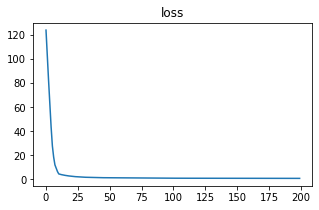

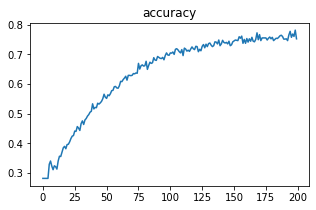

In [73]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [74]:
scores = model.evaluate(x_testcnn, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

11/11 - 0s - loss: 0.7748 - accuracy: 0.6991
accuracy: 69.91%


In [75]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(x_testcnn)
print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), labels=list(range(4)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print(f"{i} ({category_to_emotion[i]}): {j}")

Confusion matrix (rows: true classes; columns: predicted classes):

[[82  2  5 11]
 [ 3 42 25 29]
 [ 3  1 30 11]
 [ 3  3  3 76]]

Classification accuracy for each class:

0 (angry): 0.82
1 (sad): 0.42424242424242425
2 (neutral): 0.6666666666666666
3 (happy): 0.8941176470588236


# Testing on youtube videos

In [8]:
from pydub import AudioSegment
import math
import shutil


ModuleNotFoundError: No module named 'pydub'

In [77]:
parent_dir = os.getcwd() + "\\test_yt_data"
temp_path = os.path.join(parent_dir, "tmp")
try:
    shutil.rmtree(temp_path)
except:
    None

In [7]:
#

X = []
X_names = []
video_names = []
split_video_names = []
## split each video to 3 second videos and make predictions to those
for file in glob.glob("test_yt_data/*.wav"):
        file_splits = []
        basename = os.path.basename(file)
        sound = AudioSegment.from_file(file)
        three_seconds = 3 * 1000
        length = len(sound)
        splits_amount = math.ceil(length/three_seconds)
        i = 0
        parent_dir = os.getcwd() + "\\test_yt_data"
        temp_path = os.path.join(parent_dir, "tmp")
        os.mkdir(temp_path, 0o666)
        
        while (i < splits_amount):
            start_index = i * three_seconds
            end_index = start_index + three_seconds
            split = sound[start_index:end_index]
            basename_without_ext = basename.split(".")[0]
            split_video_name = f"{basename_without_ext}_split_{i}.wav"
            path = f"test_yt_data/tmp/{split_video_name}"
            split.export(path, format="wav")
            split_video_names.append(split_video_name)
            X_names.append(split_video_name)
            i = i + 1
        
        for file in glob.glob("test_yt_data/tmp/*.wav"):
            features = extract_feature(file, mfcc=True, mel=True)
            file_splits.append(features)
        shutil.rmtree(temp_path)
        video_names.append(basename)
        X.append(file_splits)

X = np.array(X)
X = X.astype(np.float32)

NameError: name 'AudioSegment' is not defined